# Active Learning on Molecular Systems with GraphDot, xTB, ASE, and scikit-learn

### Last update: 3/11/2020

## Introduction

Since the end of my PhD, I have been interested in coupling active learning with quantum calculations to explore configuration space in molecular systems. The goal of this post is to demonstrate active learning on a simple system and to put a few ideas out there for people to think about and expand on. Another reason I wanted to make this post is that I think it is ridiculously cool how seamlessly GraphDot/xTB/ASE can work together. 

I want to thank [Yu-Hang Tang](https://crd.lbl.gov/departments/computational-science/ccmc/staff/alvarez-fellows/yu-hang-tang/) for all the help with the graph kernel, none of this would have been possible otherwise. If you want to learn more about the graph kernel, check out this [publication](http://dx.doi.org/10.1063/1.5078640). 

If you have any questions or comments shoot me an email bwood@lbl.gov.

## Dependencies: 

All dependencies can be pip installed with the exception of xTB, which could be replaced with a different energy calculator if necessary.   
- [GraphDot](https://graphdot.readthedocs.io/en/latest/) 
- [xTB](https://xtb-docs.readthedocs.io/en/latest/contents.html)
- [ASE](https://wiki.fysik.dtu.dk/ase/index.html)
- scikit-learn
- Numpy
- Matplotlib

# Conformations of Polyethylene

## Description of the system

The simple example I chose to explore is learning the energy functional of an ensemble of polyethylene chain conformations. I defined the problem as follows. All chains are made up of 3 monomers — 6 carbon atoms. The rationale for short chains is to keep the degrees of freedom manageable for example purposes. Each chain consists of three C-C-C-C torsion angles and a conformation is defined as a unique set of three torsion angles. I discretized the torsion angle distribution to contain 36 states equally spaced by 10 degrees. The ensemble of conformations is generated by sampling over all of the discrete torsional configurations, so there are ~ 36^3 conformations — some of these are not unique because of symmetry.

## Description of the active learning algorithm

The objective is to find a surrogate model for calculating the energy of a chain conformation. In general, an energy evaluation with density functional theory (DFT) or another level of quantum chemistry is computationally expensive, so if we can generate a reasonable energy prediction (or predict another property of interest) with a ML model it will save computational time and expand the systems we can study. In this example I generate a graph representation of the different conformations using GraphDot and then use a graph kernel with scikit-learn’s Gaussian Process Regression (GPR) to predict energies. For this simple example we can easily calculate all the energies using xTB; however, if I wanted to use DFT or look at larger systems that would not be possible. As a result, I wanted to implement an active learning strategy. The active learning algorithm I employ is an iterative process where ~1000 conformations are predicted each step, and the 300 most uncertain conformers are fed back into the training data for the next step. This procedure is intended to ensure that the model sees data that will maximally improve the model each step.   

## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import time

In [2]:
import xtb
from xtb import GFN2

import ase
from ase.io import read, write
from ase.units import Hartree
from ase.optimize import BFGSLineSearch

In [3]:
from graphdot import Graph
from graphdot.graph.adjacency import AtomicAdjacency
from graphdot.kernel.molecular import Tang2019MolecularKernel
from graphdot.kernel.basekernel import KroneckerDelta, SquareExponential, TensorProduct
from graphdot.kernel.marginalized import MarginalizedGraphKernel

In [4]:
#%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Generate dataset via torsional configurations

Torsion angles range from 0 to 360 degrees or depending on the convention from -180 to 180 degrees. For the purposes of this demo I am going to use 0 to 360 because it fits naturally with the convention ASE uses.

In [6]:
torsion_angles = np.linspace(0.0, 350.0, num=36)

In [7]:
torsion_angles

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
       220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
       330., 340., 350.])

Generate an array of all combinations for 3 torsion angles ~46,000
this includes all combinations, not all will be unique because of symmetry

In [8]:
tor_combinations = np.zeros((46656, 3))

In [9]:
count = 0
for i in torsion_angles:
    for j in torsion_angles:
        for k in torsion_angles:
            tor_combinations[count] = [i, j, k]
            count += 1

Read in the polyethylene molecule

In [10]:
pe_mol = read("pe_n6.xyz", format="xyz")

Set the energy calculator

In [11]:
pe_mol.set_calculator(GFN2())

Check how long it takes to calculate the energy

In [12]:
%time pe_mol.get_potential_energy()

CPU times: user 172 ms, sys: 62.1 ms, total: 234 ms
Wall time: 336 ms


-543.9429312223907

## Helper functions for generating data

In [13]:
# this function randomly selects sets of torsional configurations
# it returns a list of lists, where the sample_num is number of lists and sample len is the length of each list
def random_tor_list(tor_combinations, sample_num, sample_len):
    tor_copy = np.copy(tor_combinations)
    np.random.shuffle(tor_copy)
    tor_lists = []
    for i in range(sample_num):
        j = int(i * sample_len)
        k = int(i * sample_len + sample_len)
        tor_lists.append(tor_copy[j:k])
    return tor_lists

In [14]:
# this function rotates all the torsion angles of the base molecule to the desired angles
def rotate_all_torsions(base_mol, tor_atoms, tor_angles, rot_indices):
    # copy base mol
    rot_mol = base_mol.copy()
    # loop through all the torsion angles in the conformer
    for i, atom in enumerate(tor_atoms):
        rot_mol.set_dihedral(a1=atom[0], a2=atom[1], a3=atom[2], a4=atom[3], 
                             angle=tor_angles[i], indices=rot_indices[i])
    return rot_mol

In [15]:
def generate_graphs(mols, adj):
    graph_list = [Graph.from_ase(mol, adjacency=adj) for mol in mols]
    return graph_list

In [16]:
def generate_data(base_mol, tors_list, tor_atoms, rot_indicies, adj, sample_num):
    mol_list = []
    energy_list = []
    for i, angles in enumerate(tors_list):
        rot_mol = rotate_all_torsions(base_mol, tor_atoms, angles, rot_indicies)
        rot_mol.set_calculator(GFN2())
        energy = rot_mol.get_potential_energy()
        # this if statement limits configurations to under -460.0 eV, so no overlapping atoms/unphysical structures
        # this cutoff includes ~ 90% of the total data 
        if energy < -460.0:
            mol_list.append(rot_mol)
            energy_list.append(energy)
        else:
            continue
        if len(energy_list) == sample_num:
            break
        else:
            continue
    graph_list = generate_graphs(mol_list, adj)
    return graph_list, energy_list

## Specify atoms involved in each torsion angle

In [17]:
# these are specific for this particular molecule and xyz file ordering
pe_n6_tor_atoms = [[0, 1, 5, 8], [1, 5, 8, 11], [5, 8, 11, 14]]

In [18]:
# these are specific for this particular molecule and xyz file ordering
pe_n6_tor_indices=[[8,11,12,13,14,15,16,17,18,19], [11,14,15,16,17,18,19], [14,17,18,19]]

## Generate graphs and define the graph kernel

In [19]:
adj = AtomicAdjacency(shape='tent2', zoom=2.0)

In [20]:
mol_kernel = Tang2019MolecularKernel(edge_length_scale=0.04, stopping_probability=0.01)

In order to use scikit-learn GPR we need to to define a MarginalizedGraphKernel object. The kernel defined below is essentiually the same as the Tang2019MolecularKernel.

In [21]:
kernel = MarginalizedGraphKernel(node_kernel=TensorProduct(element=KroneckerDelta(0.2)), 
                                 edge_kernel=TensorProduct(length=SquareExponential(0.04)), 
                                 q=0.01)

## Check graphs and visualize similarity matrix

In [22]:
try_tors = random_tor_list(tor_combinations, 1, 700)

In [23]:
try_graphs, try_energies = generate_data(pe_mol, try_tors[0], pe_n6_tor_atoms, pe_n6_tor_indices, adj, 500)

In [24]:
len(try_graphs), len(try_energies)

(500, 500)

In [25]:
R_mol = mol_kernel(try_graphs, lmin=1).astype(np.float)

In [26]:
D_mol = R_mol.diagonal()**-0.5

In [27]:
K_mol = D_mol[:, None] * R_mol * D_mol[None, :]

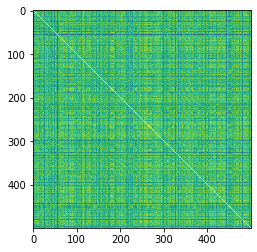

In [28]:
plt.imshow(K_mol)

In [29]:
K_mol.max()

1.0000000000000002

In [30]:
K_mol.min()

0.8540028342871165

In [31]:
R = kernel(try_graphs, lmin=1).astype(np.float)

In [32]:
D = R.diagonal()**-0.5

In [33]:
K = D[:, None] * R * D[None, :]

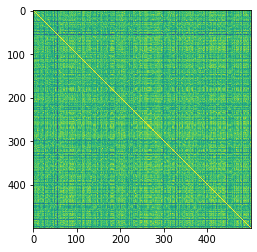

In [34]:
plt.imshow(K)

In [35]:
K.max()

1.0000000000000002

In [36]:
K.min()

0.8540028342871165

## Active learning class

In [37]:
class active_gpr():
    def __init__(self, kernel, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.uncertain = None
        self.gpr = GaussianProcessRegressor(kernel=kernel, optimizer=None, alpha=0.015, normalize_y=True)
        self.metrics = {"step": [], "rmse": [], "mae": [], "r2": []}
        self.step = 0
        
    def train(self):
        self.gpr.fit(self.X_train, self.y_train)
        y_pred = self.gpr.predict(self.X_test)
        r2 = r2_score(self.y_test, y_pred)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False) 
        mae = mean_absolute_error(self.y_test, y_pred)
        self.metrics["step"].append(self.step)
        self.metrics["rmse"].append(rmse)
        self.metrics["mae"].append(mae)
        self.metrics["r2"].append(r2)
        self.step += 1
    
    def predict(self, X_new, sample_num=300):
        y_pred, y_std = self.gpr.predict(X_new, return_std=True)
        # np.argsort sorts from min to max so selecting from the end of array gives the
        # the max uncertainty
        uncertain_indexes = np.argsort(y_std)
        self.uncertain = uncertain_indexes[(len(uncertain_indexes) - sample_num):]

    def update_data(self, X, y):
        X_new = np.array(X)[self.uncertain]
        y_new = np.array(y)[self.uncertain]
        X_train = np.concatenate((self.X_train, X_new), axis=0)
        y_train = np.concatenate((self.y_train, y_new), axis=0)
        # shuffle data
        shuffle_ind = np.arange(len(X_train))
        np.random.shuffle(shuffle_ind)
        self.X_train = X_train[shuffle_ind]
        self.y_train = y_train[shuffle_ind]

## Active learning loop

In [38]:
# define train and test torsion sets

In [39]:
def train_test_split(tor_combinations, test_size):
    tor_copy = np.copy(tor_combinations)
    np.random.shuffle(tor_copy)
    # returns the train set and test set
    train_set = tor_copy[test_size:]
    test_set = tor_copy[:test_size]
    return train_set, test_set

In [40]:
# test set size will be 3000 but the energy cutoff will remove ~ 10% of data

In [41]:
train_tor_set, test_tor_set = train_test_split(tor_combinations, test_size=4000)

In [42]:
train_tor_list = random_tor_list(train_tor_set, 11, 1500)

In [43]:
X_train_init, y_train_init = generate_data(pe_mol, train_tor_list[0], pe_n6_tor_atoms, pe_n6_tor_indices, adj, 1000)

In [44]:
X_test, y_test = generate_data(pe_mol, test_tor_set, pe_n6_tor_atoms, pe_n6_tor_indices, adj, 3000)

In [45]:
pe_gpr = active_gpr(kernel, X_train_init, y_train_init, X_test, y_test)

In [46]:
active_steps = range(0, 10)
for step in active_steps:
    s_time = time.perf_counter()
    print("Learning Step: {s}".format(s=pe_gpr.step))
    print("Training Data Size: {d}".format(d=len(pe_gpr.X_train)))
    
    pe_gpr.train()
    X_new, y_new = generate_data(pe_mol, train_tor_list[step + 1], pe_n6_tor_atoms, pe_n6_tor_indices, adj, 1000) 
    pe_gpr.predict(X_new)
    pe_gpr.update_data(X_new, y_new)
    e_time = time.perf_counter()
    
    print("MAE: {mae:0.3f}".format(mae=pe_gpr.metrics["mae"][step]))
    print("RMSE: {rmse:0.3f}".format(rmse=pe_gpr.metrics["rmse"][step]))
    print("R-squared: {r2:0.5f}".format(r2=pe_gpr.metrics["r2"][step]))
    print("Step Time(s): {t:0.2f}".format(t=(e_time - s_time)))
    print("---------- End of Step ----------")

Learning Step: 0
Training Data Size: 1000
      0.5 ms on generating jobs
      0.2 ms on creating output buffer
     14.8 ms on transferring graphs to GPU
      0.1 ms on allocate global job counter
     19.0 ms on code generation
    156.0 ms on JIT
      2.8 ms on calculating launch configuration
      5.1 ms on GPU kernel execution
    198.2 ms on calling GPU kernel (overall)
      0.0 ms on collecting result
MAE: 0.933
RMSE: 1.602
R-squared: 0.99464
Step Time(s): 50.14
---------- End of Step ----------
Learning Step: 1
Training Data Size: 1300
      0.5 ms on generating jobs
      0.3 ms on creating output buffer
     14.1 ms on transferring graphs to GPU
      0.1 ms on allocate global job counter
      9.1 ms on code generation
    161.1 ms on JIT
      2.4 ms on calculating launch configuration
      5.2 ms on GPU kernel execution
    192.5 ms on calling GPU kernel (overall)
      0.0 ms on collecting result
MAE: 0.742
RMSE: 1.102
R-squared: 0.99747
Step Time(s): 49.42
--------

## Plot MAE and RMSE

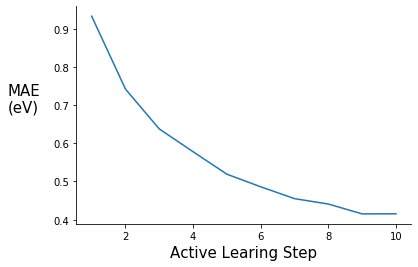

In [47]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(1,11), pe_gpr.metrics["mae"])
ax.set_xlabel('Active Learing Step', fontsize=15)
ax.set_ylabel('MAE\n(eV)', rotation=0, labelpad=30, fontsize=15)
#ax.set_ylim(0.00, 0.14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.title("", fontsize=15)
#ax.legend([], frameon=False)

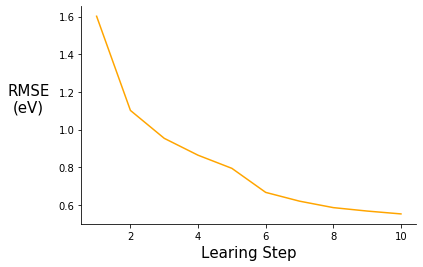

In [48]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(1,11), pe_gpr.metrics["rmse"], color="orange")
ax.set_xlabel('Learing Step', fontsize=15)
ax.set_ylabel('RMSE\n(eV)', rotation=0, labelpad=30, fontsize=15)
#ax.set_ylim(0.00, 0.14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.title("", fontsize=15)
#ax.legend([], frameon=False)